## Import necessary modules


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('drive/My Drive/Neural/SSM/Neural Analysis')

Mounted at /content/drive


In [4]:
if not os.path.isdir('lfads_demo'):
  !git clone https://github.com/lyprince/lfads_demo 
#os.chdir('lfads_demo')
sys.path.append(os.path.join(os.getcwd(), 'lfads_demo')) # To find local version of the library

In [5]:
sys.path.append(os.getcwd())

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml


# import lfads_tutorial.lfads as lfads
# import lfads_tutorial.plotting as plotting
# import lfads_tutorial.utils as utils
# from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

from lfads import LFADS_Net 
from utils import read_data, load_parameters, save_parameters

from sklearn.manifold import TSNE
import math
from lfads import batchify_random_sample


In [ ]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [ ]:
from scipy import io as sio
LATENCY = 5
assert LATENCY in [5,25]
mult = 2.5 if LATENCY == 25 else 0.5
mat = sio.loadmat(f'./chewie_CO_CS_BL_10212016_001_py_{LATENCY}ms')

num_cells = {'pmd':mat['neural_data_PMd'][0,0].shape[0], 
             'm1': mat['neural_data_M1'][0,0].shape[0],
             'all': mat['neural_data_PMd'][0,0].shape[0] +  mat['neural_data_M1'][0,0].shape[0]}

num_trials = mat['neural_data_PMd'].shape[1]

kin=mat['kinematics']
go_time_rel = mat['go_time_rel']
move_time_rel = mat['move_time_rel']
## find when cue is on to align all trials
kin_dt = 0.01
cue_on_bin= [int(mat['go_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['go_time_rel'].shape[1])]
move_bin= [int(mat['move_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['move_time_rel'].shape[1])]


ys = {'pmd':[], 'm1':[], 'all':[]}
for trial in range(num_trials):
  ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial].T,mat['neural_data_M1'][0,trial].T], axis = 1).astype(int))
  ys['pmd'].append((mat['neural_data_PMd'][0,trial].T).astype(int))
  ys['m1'].append((mat['neural_data_M1'][0,trial].T).astype(int))

#time_delta = 20
# ys = {'pmd':[], 'm1':[], 'all':[]}
# for trial in range(num_trials):
#   ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T,mat['neural_data_M1'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T], axis = 1).astype(int))
#   ys['pmd'].append((mat['neural_data_PMd'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T).astype(int))
#   ys['m1'].append((mat['neural_data_M1'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T).astype(int))

# ys = {'pmd':[], 'm1':[], 'all':[]}
# for trial in range(num_trials):
#   ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T,mat['neural_data_M1'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T], axis = 1).astype(int))
#   ys['pmd'].append((mat['neural_data_PMd'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T).astype(int))
#   ys['m1'].append((mat['neural_data_M1'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T).astype(int))


In [ ]:
# #Plot position for first trial
# import random
# tr=random.randint(0,num_trials)
# print(tr)
# kin_dt = 0.01
# go_cue_bin=int(go_time_rel[0,tr]/kin_dt)
# move_bin=int(move_time_rel[0,tr]/kin_dt)

# plt.plot(kin[0,tr][:,:2]) #Plot position
# plt.plot([go_cue_bin,go_cue_bin],[0,7],'k--')
# plt.plot([move_bin,move_bin],[0,7],'r--')
# print(move_bin)
# print(len(kin[0,tr]))
# #print(neural_data_M1[0,tr].shape[1])

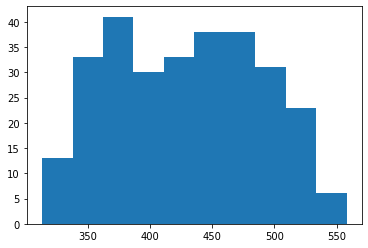

In [ ]:
# TODO: What should I do here? 
plt.hist([y.shape[0] for y in ys['all']]);

In [ ]:
num_steps = max([y.shape[0] for y in ys['all']])
ys_padded = {'all' :np.array([np.pad(ys['all'][i],((0,num_steps - ys['all'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
             'm1': np.array([np.pad(ys['m1'][i],((0,num_steps - ys['m1'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
             'pmd': np.array([np.pad(ys['pmd'][i],((0,num_steps - ys['pmd'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)])}

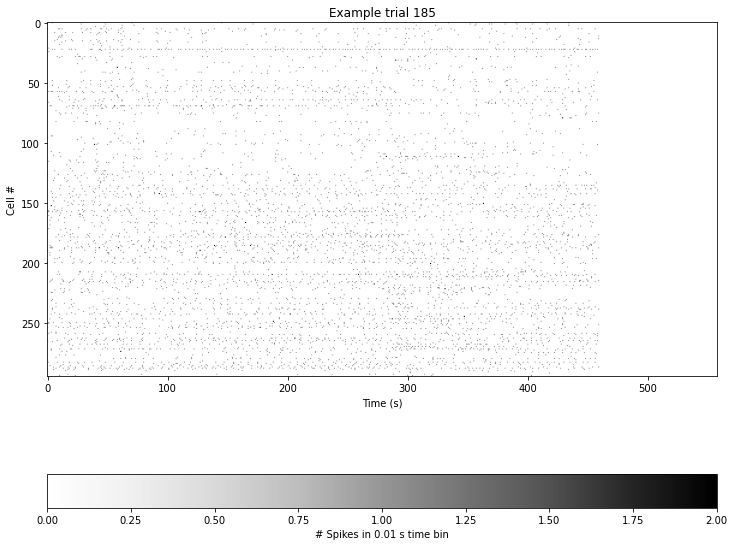

In [ ]:
plt.figure(figsize = (12,12))
random_trial = np.random.randint(num_trials)
plt.imshow(ys_padded['all'][random_trial].T, cmap=plt.cm.Greys)
#plt.xticks(np.linspace(0, 75, 6))
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='# Spikes in 0.01 s time bin')
plt.title(f'Example trial {random_trial}');

## Train LFADS model

In [ ]:
DATASET = 'm1'

train_data = torch.Tensor(ys_padded[DATASET]).to(device)
train_ds = torch.utils.data.TensorDataset(train_data)

valid_data = torch.Tensor(ys_padded[DATASET][[10],:,:]).to(device)
valid_ds = torch.utils.data.TensorDataset(valid_data)

hyperparams = load_parameters('lfads_demo/parameters_demo.yaml')
#save_parameters(hyperparams)
hyperparams['run_name'] = f'master_run_{LATENCY}ms_{DATASET}_u_prior_kappa=0.01'
hyperparams['dataset_name'] = DATASET
hyperparams['u_dim'] = 1
# hyperparams['g_dim'] = 4
# hyperparams['g0_encoder_dim'] = 128
# hyperparams['controller_dim'] = 128
# hyperparams['c_encoder_dim'] = 128
hyperparams['u_prior_kappa'] = 0.01
model = LFADS_Net(inputs_dim = num_cells[DATASET], T = num_steps, dt = 1, device=device, model_hyperparams=hyperparams, seed = 0).to(device)

Preset seed: 0


In [ ]:
hyperparams

{'betas': (0.9, 0.99),
 'c_encoder_dim': 128,
 'clip_val': 5.0,
 'controller_dim': 128,
 'dataset_name': 'm1',
 'epsilon': 0.1,
 'factors_dim': 20,
 'g0_encoder_dim': 200,
 'g0_prior_kappa': 0.1,
 'g_dim': 200,
 'keep_prob': 0.95,
 'kl_weight_schedule_dur': 2000,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 2000,
 'l2_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'run_name': 'master_run_5ms_m1_u_prior_kappa=0.01',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 1,
 'u_prior_kappa': 0.01}

In [ ]:
model.load_checkpoint('recent')

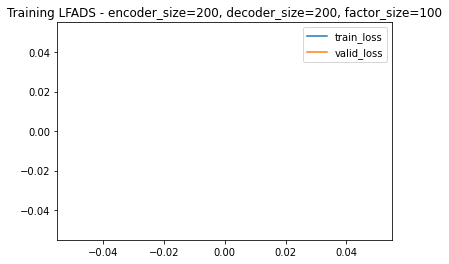

In [ ]:
plt.plot(model.train_loss_store[10:], label = 'train_loss')
plt.plot(model.valid_loss_store[10:], label = 'valid_loss')
plt.legend()
plt.title('Training LFADS - encoder_size=200, decoder_size=200, factor_size=100')
plt.show()

In [ ]:
colors = [np.floor((np.arctan2(*kin[0,tr][0,:2])/np.pi+ 0.3)*4) for tr in range(num_trials)]
  
current_epochs = 0
for max_epochs in [200]:

  model.fit(train_ds, valid_ds, max_epochs=max_epochs, batch_size=64, use_tensorboard=False)#,train_truth=train_truth, valid_truth=valid_truth)
  model.eval()
  model.batch_size = num_trials
  model.initialize(batch_size = num_trials)
  with torch.no_grad():
    model.encode(train_data)

  ic_means = model.g.to('cpu')
  ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
  plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
  plt.title('TSNE visualziation of LFADS inferred intial generator state.')
  plt.show()

Beginning training...
Epoch:    2, Step:    10, training loss: 15025.194, validation loss: 35073.961
Epoch:    3, Step:    15, training loss: 8763.915, validation loss: 9181.874
Epoch:    4, Step:    20, training loss: 8250.999, validation loss: 9297.622
Epoch:    5, Step:    25, training loss: 8185.534, validation loss: 8704.328
Epoch:    6, Step:    30, training loss: 8026.566, validation loss: 9336.163
Epoch:    7, Step:    35, training loss: 7845.001, validation loss: 13948.316
Epoch:    8, Step:    40, training loss: 7673.155, validation loss: 10060.815
Epoch:    9, Step:    45, training loss: 7671.577, validation loss: 9838.105
Epoch:   10, Step:    50, training loss: 7610.440, validation loss: 9117.638
Epoch:   11, Step:    55, training loss: 7605.755, validation loss: 9297.221
Epoch:   12, Step:    60, training loss: 7741.679, validation loss: 9813.289
Epoch:   13, Step:    65, training loss: 7618.645, validation loss: 9603.120
Epoch:   14, Step:    70, training loss: 7546.237,

FileNotFoundError: ignored

In [ ]:
model??

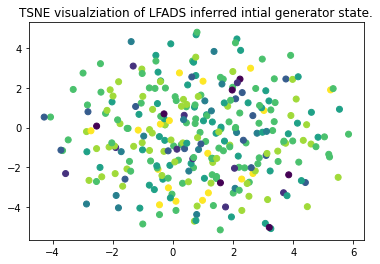

In [ ]:
model.eval()
model.batch_size = num_trials
model.initialize(batch_size = num_trials)
with torch.no_grad():
  model.encode(train_data)

ic_means = model.g.to('cpu')
ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
plt.title('TSNE visualziation of LFADS inferred intial generator state.')
plt.show()

In [ ]:
# TODO: DELETE
# batch_size = 20
# xs_padded = []
# factors_padded = [] 
# for ix in range(ys_padded[DATASET].shape[0]):
#   if ix%50 == 0:
#     print(ix)
#   batch = train_data[ix].unsqueeze(0).repeat(batch_size, 1,1)
#   pred_data = model.reconstruct(batch)
#   inferred_factors = model.infer_factors(batch)
#   true_data = train_data[ix].cpu().numpy()
#   xs_padded.append(pred_data)
#   factors_padded.append(inferred_factors.mean(dim=0).cpu().numpy())
#   #model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=4)

# xs = [xs_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET])]
# factors = [factors_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET])]

# if not os.path.exists(f'./output/{model.run_name}'):
#   os.mkdir(f'./output/{model.run_name}')
# np.save(f'./output/{model.run_name}/xs_{DATASET}.npy', xs)
# np.save(f'./output/{model.run_name}/xs_{DATASET}_padded.npy', xs_padded)
# np.save(f'./output/{model.run_name}/factors_{DATASET}.npy', factors)
# np.save(f'./output/{model.run_name}/factors_{DATASET}_padded.npy', factors_padded)
 

In [ ]:
batch_size = 5 #20
xs_padded = []
factors_padded = [] 
inputs_padded = []
for ix in range(ys_padded[DATASET].shape[0]):
  if ix%50 == 0:
    print(ix)
  
  batch = train_data[ix].unsqueeze(0).repeat(batch_size, 1,1)
  model.eval()
  model.batch_size = batch_size
  prev_save = model.save_variables
  with torch.no_grad():
      model.save_variables = True
      model(batch)
  pred_data = model.rates.mean(dim=0).cpu().numpy()
  inferred_factors = model.factors.mean(dim=0).cpu().numpy()
  inputs = model.inputs.mean(dim=0).cpu().numpy()
  xs_padded.append(pred_data)
  factors_padded.append(inferred_factors)
  inputs_padded.append(inputs)
  #true_data = train_data[ix].cpu().numpy()
  #model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=4)

xs = [xs_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET][:23])]
factors = [factors_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET][:23])]
inputs = [inputs_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET][:23])]


if not os.path.exists(f'./output/lfads/{model.run_name}'):
  os.mkdir(f'./output/lfads/{model.run_name}')
np.save(f'./output/lfads/{model.run_name}/xs_{DATASET}.npy', xs)
np.save(f'./output/lfads/{model.run_name}/xs_{DATASET}_padded.npy', xs_padded)
np.save(f'./output/lfads/{model.run_name}/factors_{DATASET}.npy', factors)
np.save(f'./output/lfads/{model.run_name}/factors_{DATASET}_padded.npy', factors_padded)
np.save(f'./output/lfads/{model.run_name}/inputs_{DATASET}.npy', inputs)
np.save(f'./output/lfads/{model.run_name}/inputs_{DATASET}_padded.npy', inputs_padded)


0
50
100
150
200
250


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
inputs[0].shape

(463, 2)

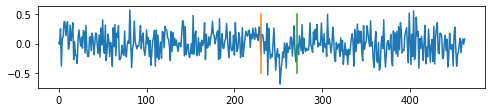

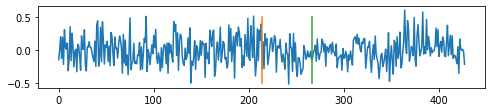

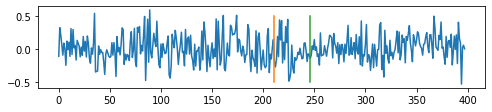

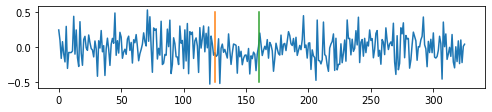

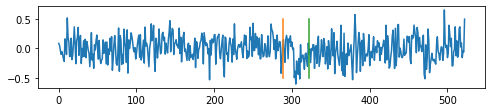

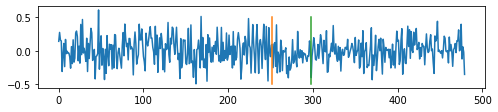

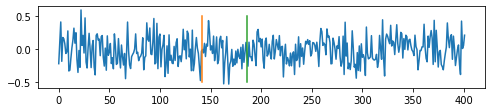

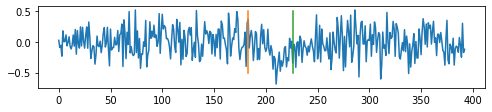

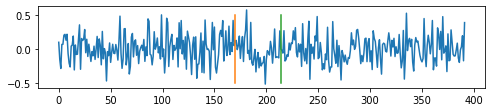

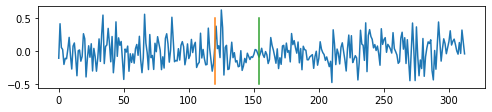

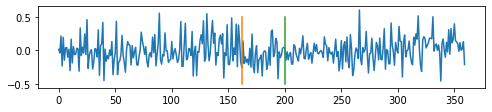

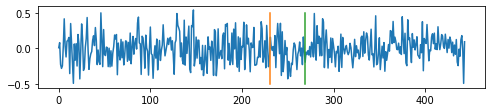

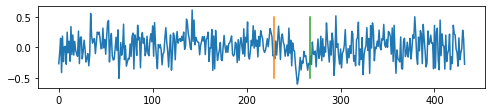

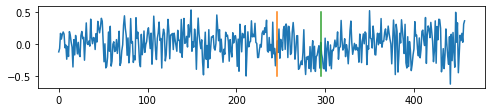

In [ ]:
inputs = np.load(f'./output/lfads/{model.run_name}/inputs_{DATASET}.npy', allow_pickle = True).tolist()
for idx in range(20):
  #idx = 8
  if cue_on_bin[idx] < move_bin[idx]:
    plt.figure(figsize = (8,1.5))
    plt.plot(inputs[idx]);
    plt.plot([cue_on_bin[idx], cue_on_bin[idx]],[-0.5,0.5])
    plt.plot([move_bin[idx], move_bin[idx]], [-0.5,0.5])
    plt.show()

51


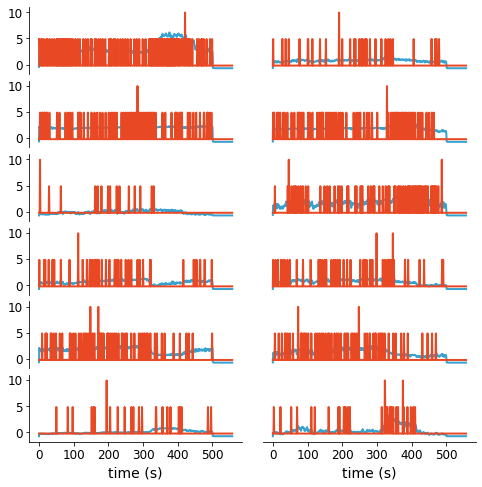

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
#plt.show()

0.21854073114160988


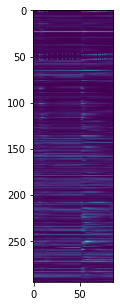

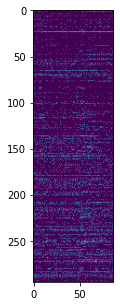

In [ ]:
from scipy.stats import poisson
import random
trial = random.randint(0,100)
print(poisson.pmf(ys[DATASET][trial].T,xs[trial].T)[ys[DATASET][trial].T !=0].mean())
plt.figure(figsize = (5,5))
plt.imshow(xs[trial].T)
plt.figure(figsize = (5,5))
plt.imshow(ys[DATASET][trial].T)

## Plot results summary 

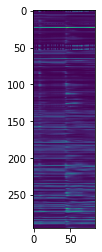

In [ ]:
plt.imshow(xs[100].T);

2


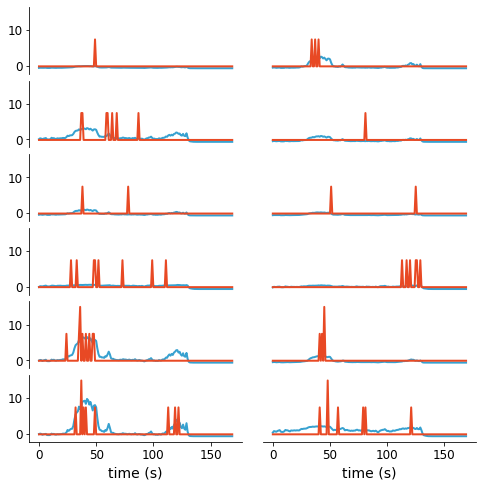

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(valid_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)*10
true_data = valid_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
#plt.show()

In [ ]:
valid_data.shape

torch.Size([3, 170, 94])

In [ ]:
model.plot_traces??

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=False,num_traces=6)

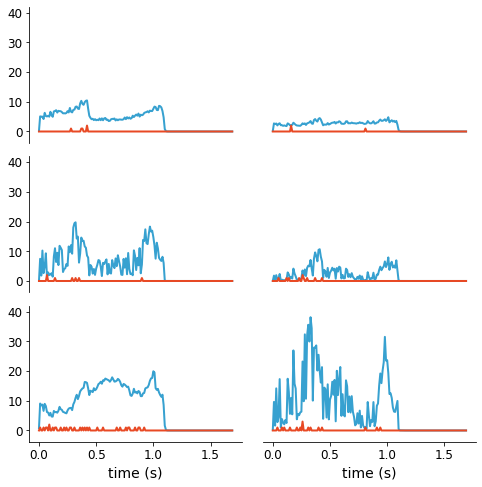

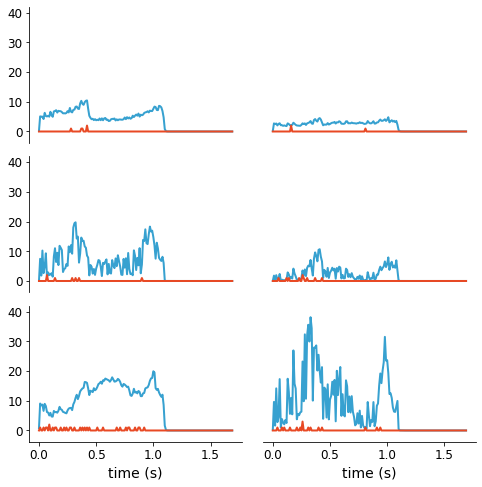

In [ ]:
batch_size = 100
ix = 0
batch = train_data[ix].unsqueeze(0).repeat(batch_size, 1, 1)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=False,num_traces=6)

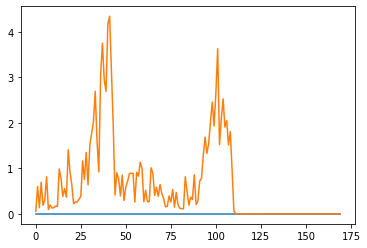

In [ ]:
plt.plot(true_data[:,1])
plt.plot(pred_data[:,1])
#plt.plot(ys['pmd'][0][:,1])  
plt.show()

## Check iterations

In [ ]:
os.listdir('output/iterations')

['xs_pmd_500.npy',
 'xs_pmd_padded_500.npy',
 'xs_pmd_1000.npy',
 'xs_pmd_padded_1000.npy',
 'xs_pmd_1500.npy',
 'xs_pmd_padded_1500.npy',
 'xs_pmd_2000.npy',
 'xs_pmd_padded_2000.npy',
 'xs_pmd_2500.npy',
 'xs_pmd_padded_2500.npy',
 'xs_pmd_3000.npy',
 'xs_pmd_padded_3000.npy',
 'xs_pmd_3500.npy',
 'xs_pmd_padded_3500.npy',
 'xs_pmd_4000.npy',
 'xs_pmd_padded_4000.npy',
 'xs_pmd_4500.npy',
 'xs_pmd_padded_4500.npy',
 'xs_pmd_5000.npy',
 'xs_pmd_padded_5000.npy',
 'xs_pmd_5500.npy',
 'xs_pmd_padded_5500.npy',
 'xs_pmd_6000.npy',
 'xs_pmd_padded_6000.npy',
 'xs_pmd_6500.npy',
 'xs_pmd_padded_6500.npy',
 'xs_pmd_7000.npy',
 'xs_pmd_padded_7000.npy',
 'xs_pmd_7500.npy',
 'xs_pmd_padded_7500.npy',
 'xs_pmd_8000.npy',
 'xs_pmd_padded_8000.npy',
 'xs_pmd_8500.npy',
 'xs_pmd_padded_8500.npy',
 'xs_pmd_9000.npy',
 'xs_pmd_padded_9000.npy',
 'xs_pmd_9500.npy',
 'xs_pmd_padded_9500.npy',
 'xs_pmd_10000.npy',
 'xs_pmd_padded_10000.npy']

In [ ]:
xss = [np.load(f'output/iterations/xs_pmd_{i}.npy', allow_pickle = True) for i in range(500,10000,500)]
  

In [ ]:
for i in range(len(xss)):
  plt.imshow(xss[i][0].T)
  plt.show()

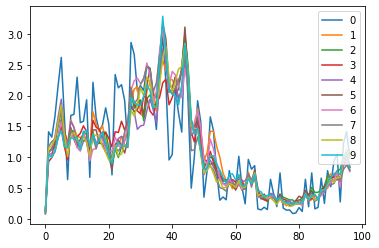

In [ ]:
for i in range(len(xss))[:10]:
  plt.plot(xss[i][0][:,1],label = i)
plt.legend()
plt.show()

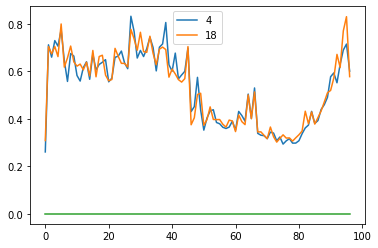

In [ ]:
for i in [4,18]:
  plt.plot(xss[i][0][:,19],label = i)
plt.plot(ys['pmd'][0][:,19])  
plt.legend()
plt.show()

In [ ]:
for i in range(94):
  plt.plot(xss[18][0][:,i],label = i)
  plt.plot(ys['pmd'][0][:,i])  
  plt.legend()
  plt.show()

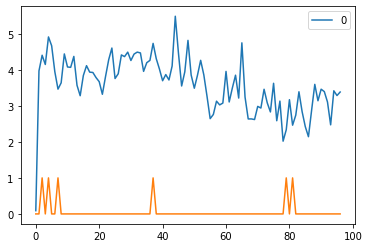

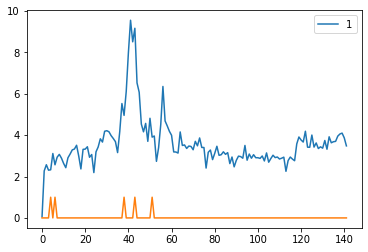

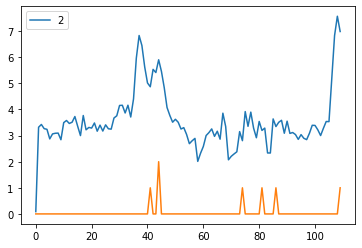

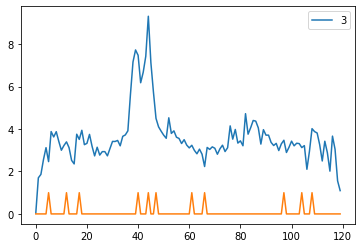

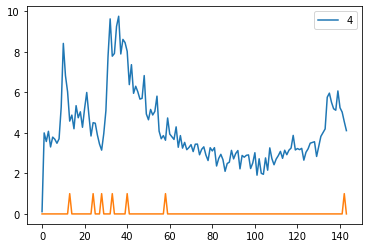

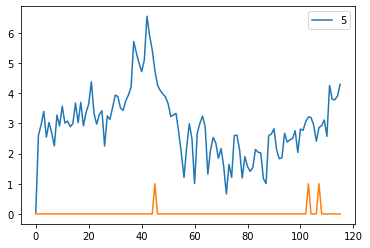

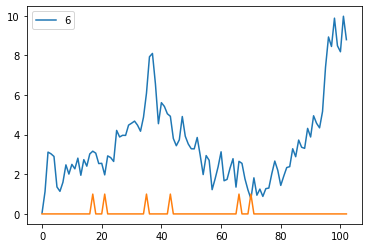

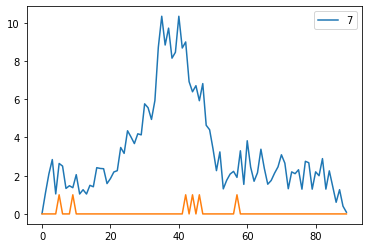

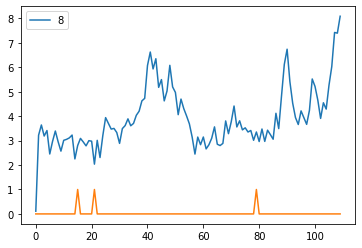

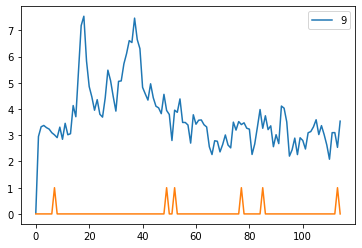

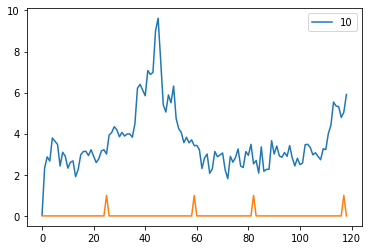

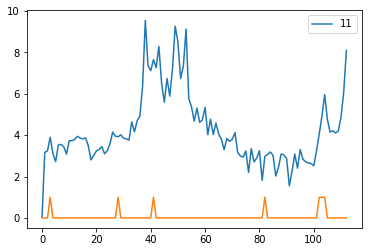

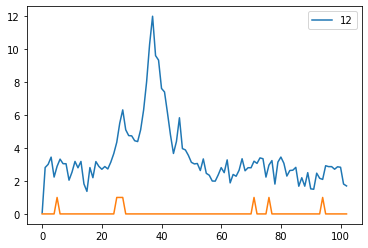

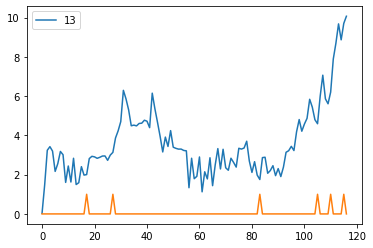

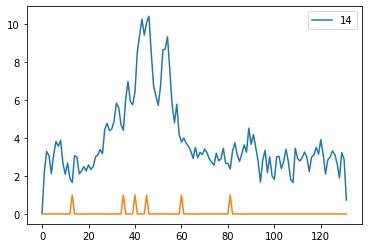

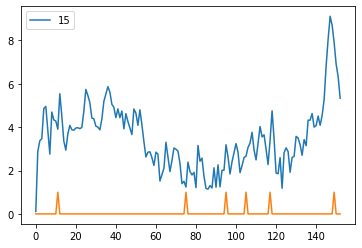

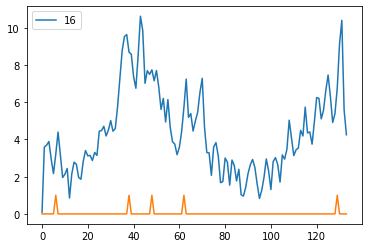

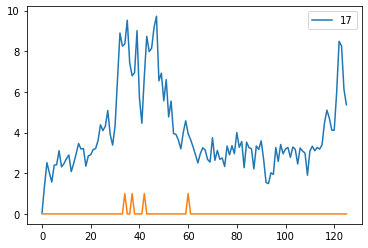

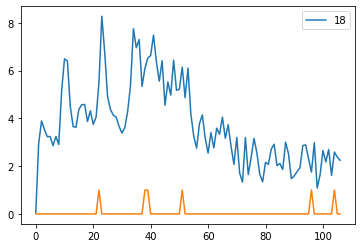

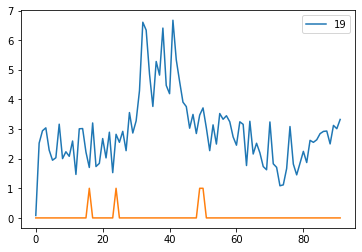

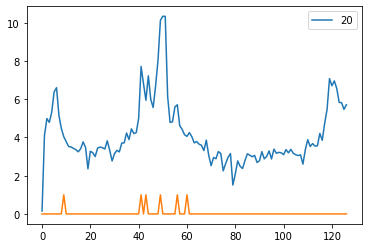

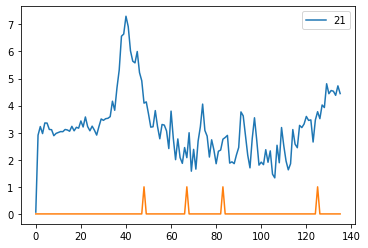

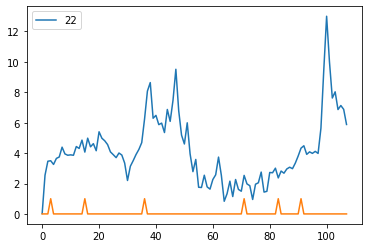

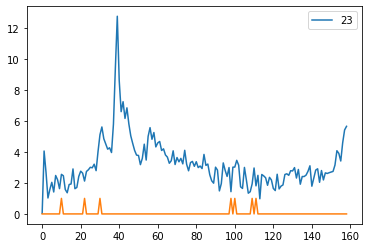

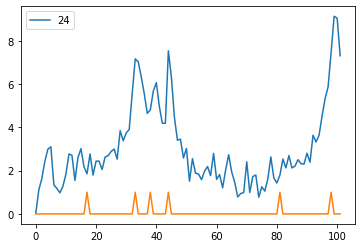

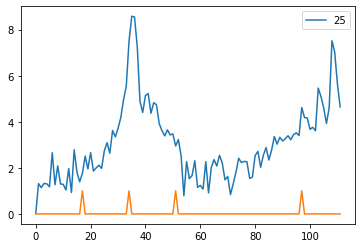

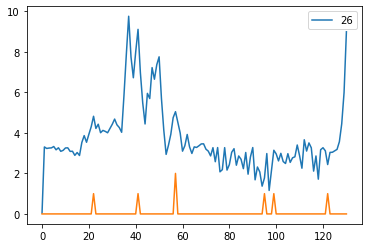

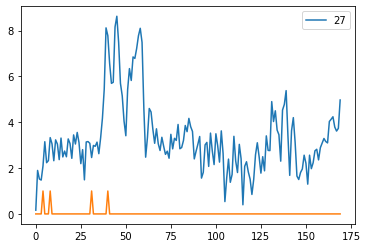

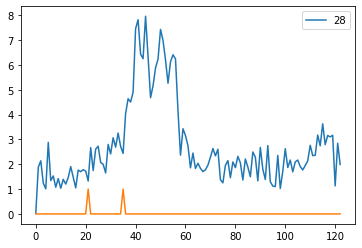

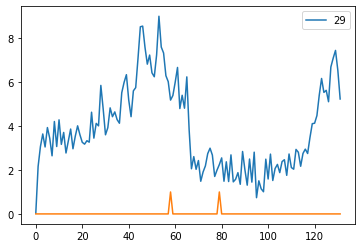

In [ ]:
for i in range(30):
  plt.plot(xss[0][i][:,85],label = i)
  plt.plot(ys['pmd'][i][:,85])  
  plt.legend()
  plt.show()

In [ ]:
xss[i][0][:,1].shape

(97,)

In [ ]:
ys['pmd'][3][:,1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
ys['pmd'][1].shape

(142, 94)

In [ ]:
model_path = 'models/pmd/iterations/checkpoints'
for epath in os.listdir(model_path):
models = [os.path.join(model_path, epath) ])   
os.listdir('models/pmd/iterations/checkpoints')
model = LFADS_Net(inputs_dim = num_cells[DATASET], T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams, seed = 0).to(device)
model.save_checkpoint(force = True, output= '.')


['2012150217_epoch_500_loss_1354-3551025390625.pth',
 '2012150232_epoch_728_loss_1333-013427734375.pth',
 '2012150242_epoch_908_loss_1329-2835693359375.pth',
 '2012150247_epoch_1000_loss_1342-3978271484375.pth',
 '2012150306_epoch_1293_loss_1325-8841552734375.pth',
 '2012150316_epoch_1471_loss_1345-869384765625.pth',
 '2012150319_epoch_1471_loss_1345-869384765625.pth',
 '2012150322_epoch_1471_loss_1345-869384765625.pth',
 '2012150324_epoch_1471_loss_1345-869384765625.pth',
 '2012150327_epoch_1471_loss_1345-869384765625.pth',
 '2012150330_epoch_1471_loss_1345-869384765625.pth',
 '2012150332_epoch_1471_loss_1345-869384765625.pth',
 '2012150335_epoch_1471_loss_1345-869384765625.pth',
 '2012150338_epoch_1471_loss_1345-869384765625.pth',
 '2012150340_epoch_1471_loss_1345-869384765625.pth',
 '2012150343_epoch_1471_loss_1345-869384765625.pth',
 '2012150345_epoch_1471_loss_1345-869384765625.pth',
 '2012150348_epoch_1471_loss_1345-869384765625.pth',
 '2012150351_epoch_1471_loss_1345-86938476562

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 10)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=4)

In [ ]:
  

  
  # batch_example, ix = batchify_random_sample(train_data, 20)
  # print(ix)
  # pred_data = model.reconstruct(batch_example)*10
  # true_data = train_data[ix].cpu().numpy()
  # model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
  # plt.show()

  # model.eval()
  # model.batch_size = 496
  # model.initialize(batch_size = 496)
  # with torch.no_grad():
  #   model.encode(train_data[:496,:,:])

  # ic_means = model.g0_mean.to('cpu')
  # ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
  # plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
  # plt.title('TSNE visualziation of LFADS inferred intial generator state.')
  # plt.show()

  #current_epochs += max_epochs 